In [2]:
from pynq import allocate
from pynq import Overlay
import numpy as np
import pynq.lib.dma
import time
import pynq
import pandas as pd

In [3]:
weight_0 = np.load('weights/weight_0.npy')
weight_1 = np.load('weights/weight_1.npy')
weight_2 = np.load('weights/weight_2.npy')
weight_3 = np.load('weights/weight_3.npy')
bias_0 = np.load('weights/bias_0.npy')
bias_1 = np.load('weights/bias_1.npy')
bias_2 = np.load('weights/bias_2.npy')
bias_3 = np.load('weights/bias_3.npy')
test = np.loadtxt("dataset/test.csv", delimiter=',', skiprows=1, usecols=np.arange(0,561))
data_label = pd.read_csv("dataset/test.csv")['Activity']

In [4]:
test_size = 300
np.random.seed(2)
a = np.arange(2000)
np.random.shuffle(a)
a = a[:test_size]
testset = test[a]
testset.shape

(300, 561)

## FPGA INITIALIZATION

In [5]:
overlay = Overlay('bitstream.bit')   # load bitstream inside FPGA
dma = overlay.axi_dma_0    
input_buffer0 = allocate(shape=(561,), dtype=np.float32)
input_buffer1 = allocate(shape=(64,), dtype=np.float32)
input_buffer2 = allocate(shape=(6,), dtype=np.float32)
output_buffer0 = allocate(shape=(6,), dtype=np.float32)

In [6]:
##weights
for i in range(64):
    for k in range(561):
        input_buffer0[k] = weight_0[k][i]
    dma.sendchannel.transfer(input_buffer0)
    dma.sendchannel.wait()
for i in range(64):
    for k in range(64):
        input_buffer1[k] = weight_1[k][i]
    dma.sendchannel.transfer(input_buffer1)
    dma.sendchannel.wait()
for i in range(64):
    for k in range(64):
        input_buffer1[k] = weight_2[k][i]
    dma.sendchannel.transfer(input_buffer1)
    dma.sendchannel.wait()
for i in range(6):
    for k in range(64):
        input_buffer1[k] = weight_3[k][i]
    dma.sendchannel.transfer(input_buffer1)
    dma.sendchannel.wait()
##bias
for k in range(64):
    input_buffer1[k] = bias_0[k]
dma.sendchannel.transfer(input_buffer1)
dma.sendchannel.wait()
for k in range(64):
    input_buffer1[k] = bias_1[k]
dma.sendchannel.transfer(input_buffer1)
dma.sendchannel.wait()
for k in range(64):
    input_buffer1[k] = bias_2[k]
dma.sendchannel.transfer(input_buffer1)
dma.sendchannel.wait()
for k in range(6):
    input_buffer2[k] = bias_3[k]
dma.sendchannel.transfer(input_buffer2)
dma.sendchannel.wait()

In [7]:
import asyncio
async_result = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

async def calculation():
    global async_result
    dma.sendchannel.transfer(input_buffer0)
    dma.recvchannel.transfer(output_buffer0)
    await asyncio.ensure_future(dma.sendchannel.wait_async())
    await asyncio.ensure_future(dma.recvchannel.wait_async())
    async_result = np.row_stack((async_result, output_buffer0))

In [8]:
def fpga_evaluate_async(testcount, test):
    loop = asyncio.get_event_loop()
    global async_result
    async_result = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    for i in range(test_size):
        for j in range(561):
            input_buffer0[j] = test[i][j];
        loop.run_until_complete(calculation())
    return async_result[1:]

In [9]:
def fpga_evaluate(testcount, test):
    result = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    for i in range(test_size):
        for j in range(561):
            input_buffer0[j] = test[i][j];
        dma.sendchannel.transfer(input_buffer0)
        dma.recvchannel.transfer(output_buffer0)
        dma.sendchannel.wait()
        dma.recvchannel.wait()
        result = np.row_stack((result, output_buffer0))
    return result[1:]

## CPU INITIALIZATION

In [10]:
buffer_0 = np.zeros(64);
buffer_1 = np.zeros(64);
buffer_2 = np.zeros(64);
buffer_3 = np.zeros(6);

def cpu_evaluate(testcount, test):
    result = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    for i in range(testcount):
        for j in range(64):
            buffer_0[j] = np.dot(test[i], weight_0[:, [j]]) + bias_0[j]
            if buffer_0[j] < 0:
                buffer_0[j] = 0
        for j in range(64):
            buffer_1[j] = np.dot(buffer_0, weight_1[:, [j]]) + bias_1[j]
            if buffer_1[j] < 0:
                buffer_1[j] = 0
        for j in range(64):
            buffer_2[j] = np.dot(buffer_1, weight_2[:, [j]]) + bias_2[j]
            if buffer_2[j] < 0:
                buffer_2[j] = 0
        for j in range(6):
            buffer_3[j] = np.dot(buffer_2, weight_3[:, [j]]) + bias_3[j]
        result = np.row_stack((result, buffer_3))
    return result[1:]

## POWER METRIC

In [11]:
rails = pynq.get_rails()
recorder1 = pynq.DataRecorder(rails['PSINT_FP'].power, rails['PSPLL'].power)
recorder2 = pynq.DataRecorder(rails['PSINT_FP'].power, rails['PSPLL'].power)

## FPGA PERFORMANCE

Time taken = 0.967414379119873


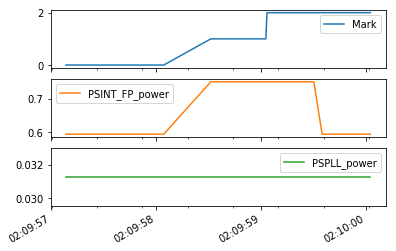

In [13]:
fpga_time = time.time()

recorder1.reset()
with recorder1.record(0.00001):
    time.sleep(1)
    recorder1.mark()
    timestart = time.time()
    fpga_res = fpga_evaluate(test_size, testset)
    timeend = time.time()
    recorder1.mark()
    time.sleep(1)
    fpga_time = timeend-timestart
print('Time taken = ' + str(fpga_time))    
recorder1.frame.plot(subplots=True)
fpga_res = np.argmax(fpga_res, axis=-1)

Time taken = 1.2459633350372314


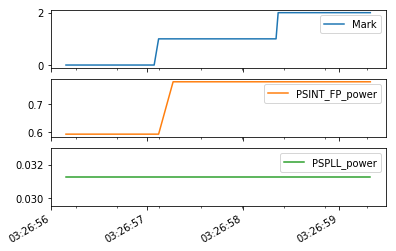

In [46]:
fpga_async_time = time.time()

recorder1.reset()
with recorder1.record(0.01):
    time.sleep(1)
    recorder1.mark()
    timestart = time.time()
    fpga_res_async = fpga_evaluate_async(test_size, testset)
    timeend = time.time()
    recorder1.mark()
    time.sleep(1)
    fpga_async_time = timeend-timestart
print('Time taken = ' + str(fpga_async_time))    
recorder1.frame.plot(subplots=True)
fpga_res_async = np.argmax(fpga_res_async, axis=-1)

## CPU PERFORMANCE

Time taken = 9.662940740585327


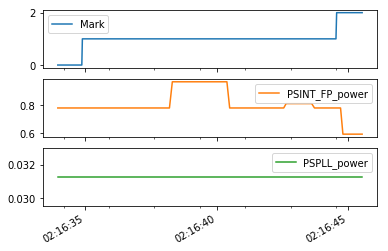

In [17]:
cpu_time = time.time()

recorder2.reset()
with recorder2.record(0.01):
    time.sleep(1)
    recorder2.mark()
    timestart = time.time()
    cpu_res = cpu_evaluate(test_size, testset)
    timeend = time.time()
    recorder2.mark()
    time.sleep(1)
    cpu_time = timeend-timestart
print('Time taken = ' + str(cpu_time))    
recorder2.frame.plot(subplots=True)
cpu_res = np.argmax(cpu_res, axis=-1)

## ACCURACY & SPEED

### Synchronous

In [48]:
print('Results matched = ' + str(np.sum((cpu_res == fpga_res).astype(int))/cpu_res.shape[0] * 100) + '%')
print('Speedup factor = ' + str(cpu_time/fpga_time))

Results matched = 100.0%
Speedup factor = 8.682046563362558


In [49]:
labels = np.array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'])
decoded_predictions = labels[fpga_res]

In [50]:
from IPython.display import display
dataset = pd.DataFrame({'FPGA predictions': decoded_predictions, 'Actual test label': data_label[a]}).reset_index(drop=True)
pd.set_option('display.max_rows', 300)
pd.set_option('display.height', 300)
display(dataset)

,Actual test label,FPGA predictions
0,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
1,STANDING,SITTING
2,LAYING,LAYING
3,WALKING,WALKING
4,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
5,WALKING,WALKING
6,WALKING_UPSTAIRS,WALKING_UPSTAIRS
7,LAYING,LAYING
8,STANDING,STANDING
9,WALKING,WALKING


In [51]:
print('Results matched = ' + str(np.sum((decoded_predictions == data_label[a]).astype(int))/decoded_predictions.shape[0] * 100) + '%')

Results matched = 95.66666666666667%


### Asynchronous

In [39]:
print('Results matched = ' + str(np.sum((cpu_res == fpga_res_async).astype(int))/cpu_res.shape[0] * 100) + '%')
print('Speedup factor = ' + str(cpu_time/fpga_async_time))

Results matched = 100.0%
Speedup factor = 6.449962537742323


In [40]:
from pynq import ps
ps.Clocks.fclk0_mhz = 50
ps.Clocks.fclk1_mhz = 50
ps.Clocks.fclk2_mhz = 50
ps.Clocks.fclk3_mhz = 50

Time taken = 1.100219964981079


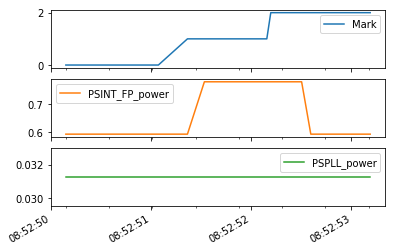

In [247]:
recorder1.reset()
with recorder1.record(0.01):
    time.sleep(1)
    recorder1.mark()
    timestart = time.time()
    fpga_res = fpga_evaluate(test_size, testset)
    timeend = time.time()
    recorder1.mark()
    time.sleep(1)
    fpga_time = timeend-timestart
print('Time taken = ' + str(fpga_time))    
recorder1.frame.plot(subplots=True)
fpga_res = np.argmax(fpga_res, axis=-1)

In [239]:
ps.Clocks.fclk0_mhz

49.9995

In [241]:
from pynq import pl
pl.HWH

pynq.pl_server.hwh_parser._HWHUltrascale

In [274]:
ps.Clocks.fclk0_mhz = 50
ps.Clocks.fclk1_mhz = 50
ps.Clocks.fclk2_mhz = 50
ps.Clocks.fclk3_mhz = 50
rails = pynq.get_rails()
rails

{'1V2': Rail {name=1V2, voltage=Sensor {name=1V2_voltage, value=1.199V}, current=Sensor {name=1V2_current, value=0.0A}, power=Sensor {name=1V2_power, value=0.0W}},
 '3V3': Rail {name=3V3, voltage=Sensor {name=3V3_voltage, value=3.296V}, current=Sensor {name=3V3_current, value=0.14A}, power=Sensor {name=3V3_power, value=0.4375W}},
 '3V3_D': Rail {name=3V3_D, voltage=Sensor {name=3V3_D_voltage, value=3.304V}, current=Sensor {name=3V3_D_current, value=0.001A}, power=Sensor {name=3V3_D_power, value=0.0W}},
 'AUX': Rail {name=AUX, voltage=Sensor {name=AUX_voltage, value=1.8V}, current=Sensor {name=AUX_current, value=0.015A}, power=Sensor {name=AUX_power, value=0.0W}},
 'INT': Rail {name=INT, voltage=Sensor {name=INT_voltage, value=0.847V}, current=Sensor {name=INT_current, value=0.265A}, power=Sensor {name=INT_power, value=0.21875W}},
 'PSAUX': Rail {name=PSAUX, voltage=Sensor {name=PSAUX_voltage, value=1.8V}, current=Sensor {name=PSAUX_current, value=0.171A}, power=Sensor {name=PSAUX_power

In [41]:
ps.Clocks.fclk0_mhz = 100
ps.Clocks.fclk1_mhz = 100
ps.Clocks.fclk2_mhz = 100
ps.Clocks.fclk3_mhz = 100
rails = pynq.get_rails()
rails

{'1V2': Rail {name=1V2, voltage=Sensor {name=1V2_voltage, value=1.207V}, current=Sensor {name=1V2_current, value=0.0A}, power=Sensor {name=1V2_power, value=0.0W}},
 '3V3': Rail {name=3V3, voltage=Sensor {name=3V3_voltage, value=3.296V}, current=Sensor {name=3V3_current, value=0.234A}, power=Sensor {name=3V3_power, value=0.71875W}},
 '3V3_D': Rail {name=3V3_D, voltage=Sensor {name=3V3_D_voltage, value=3.304V}, current=Sensor {name=3V3_D_current, value=0.001A}, power=Sensor {name=3V3_D_power, value=0.0W}},
 'AUX': Rail {name=AUX, voltage=Sensor {name=AUX_voltage, value=1.796V}, current=Sensor {name=AUX_current, value=0.015A}, power=Sensor {name=AUX_power, value=0.0W}},
 'INT': Rail {name=INT, voltage=Sensor {name=INT_voltage, value=0.847V}, current=Sensor {name=INT_current, value=0.359A}, power=Sensor {name=INT_power, value=0.28125W}},
 'PSAUX': Rail {name=PSAUX, voltage=Sensor {name=PSAUX_voltage, value=1.796V}, current=Sensor {name=PSAUX_current, value=0.171A}, power=Sensor {name=PSAUX